In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm, trange

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.datasets import load_iris
from sklearn import preprocessing

from torchsummary import summary

In [2]:
torch.manual_seed(1337)
class Net(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 3)
        self.fc2 = nn.Linear(3, 4)
        self.fc3 = nn.Linear(4, 3)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)

        return x

In [3]:
iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

scaller = preprocessing.MinMaxScaler(feature_range=(-1, 1))
X_scaled = scaller.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, train_size=0.8)

In [4]:
model = Net(X_train.shape[1])
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
model

Net(
  (fc1): Linear(in_features=4, out_features=3, bias=True)
  (fc2): Linear(in_features=3, out_features=4, bias=True)
  (fc3): Linear(in_features=4, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)

In [5]:
epochs = 2500
X_train = Variable(torch.from_numpy(X_train)).float()
# X_train = Variable(X_train).float()
y_train = Variable(torch.from_numpy(y_train)).long()
# y_train = Variable(y_train).long()
X_test = Variable(torch.from_numpy(X_test)).float()
# X_test = Variable(X_test).float()
y_test = Variable(torch.from_numpy(y_test)).long()
# y_test = Variable(y_test).long()

In [6]:
loss_list = np.zeros((epochs,))
accuracy_list = np.zeros((epochs,))

for epoch in trange(epochs):
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    loss_list[epoch] = loss.item()
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        y_pred = model(X_test)
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()

0.9333333373069763


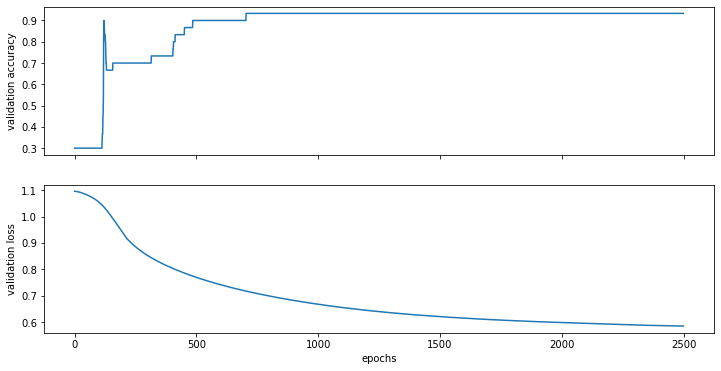

In [7]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list)
ax1.set_ylabel("validation accuracy")
ax2.plot(loss_list)
ax2.set_ylabel("validation loss")
ax2.set_xlabel("epochs");
print(max(accuracy_list))

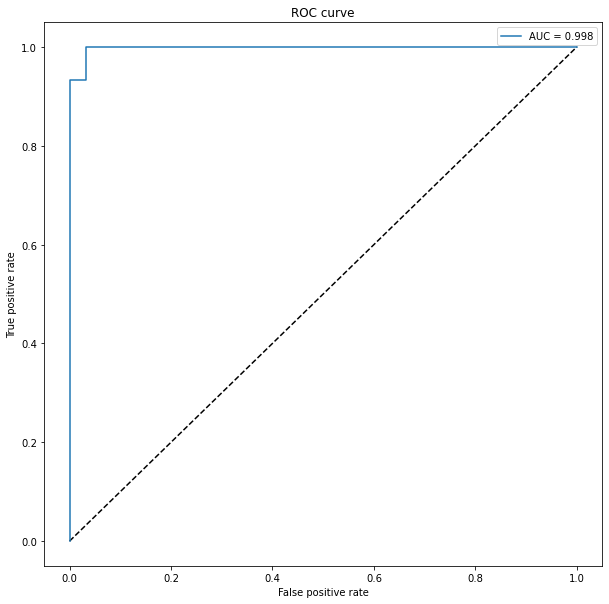

In [8]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder

plt.figure(figsize=(10, 10))
plt.plot([0, 1], [0, 1], 'k--')

enc = OneHotEncoder()
Y_onehot = enc.fit_transform(y_test[:, np.newaxis]).toarray()

with torch.no_grad():
    y_pred = model(X_test).numpy()
    fpr, tpr, threshold = roc_curve(Y_onehot.ravel(), y_pred.ravel())
    
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend();